# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import matplotlib as mpl
mpl.use('TkAgg')
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        #print(x.shape)
        batch_size, sizee1, sizee2, sizee3   = x.shape
        return x.view(batch_size, -1)

('SVHN data sample shape: ', torch.Size([3, 32, 32]))


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [6]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        #if scheduler is not None:
        #    scheduler.step()
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        if scheduler is not None:
            scheduler.step()
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    
    #raise Exception("Not implemented")
    correct_samples = 0
    total_samples = 0
    for i, (x, y) in enumerate(loader):
        prediction = model(x)
        indices = torch.argmax(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
        
    accuracy = float(correct_samples) / total_samples    
    
    
    return accuracy

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.824540, Train accuracy: 0.411272, Val accuracy: 0.549655
Average loss: 1.456627, Train accuracy: 0.582756, Val accuracy: 0.600915
Average loss: 1.379687, Train accuracy: 0.617411, Val accuracy: 0.621937


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [7]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.191005, Train accuracy: 0.190834, Val accuracy: 0.213228
Average loss: 2.048029, Train accuracy: 0.243985, Val accuracy: 0.295133
Average loss: 1.854131, Train accuracy: 0.355305, Val accuracy: 0.406798
Average loss: 1.719777, Train accuracy: 0.420554, Val accuracy: 0.433691
Average loss: 1.684818, Train accuracy: 0.433539, Val accuracy: 0.454986


Добавьте слой с Batch Normalization

In [8]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.082650, Train accuracy: 0.300140, Val accuracy: 0.438264
Average loss: 1.781660, Train accuracy: 0.481487, Val accuracy: 0.556140
Average loss: 1.632435, Train accuracy: 0.559090, Val accuracy: 0.607672
Average loss: 1.541242, Train accuracy: 0.597226, Val accuracy: 0.619139
Average loss: 1.481713, Train accuracy: 0.620329, Val accuracy: 0.615453


Добавьте уменьшение скорости обучения по ходу тренировки.

In [9]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

Average loss: 2.069163, Train accuracy: 0.307033, Val accuracy: 0.444953
Average loss: 1.769290, Train accuracy: 0.472341, Val accuracy: 0.531500
Average loss: 1.660892, Train accuracy: 0.528837, Val accuracy: 0.560713
Average loss: 1.611037, Train accuracy: 0.551565, Val accuracy: 0.584943
Average loss: 1.575614, Train accuracy: 0.570607, Val accuracy: 0.590676


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [10]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    #raise Exception("Not implemented")
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=SubsetSampler(indices))
    
    predictions = []
    ground_truth = []
    for i, (x, y) in enumerate(loader):
        prediction = model(x)
        indicees = torch.argmax(prediction, 1)
        
        predictions += list(indicees.numpy())
        ground_truth += list(y.numpy())
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

![image.png](attachment:image.png)

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

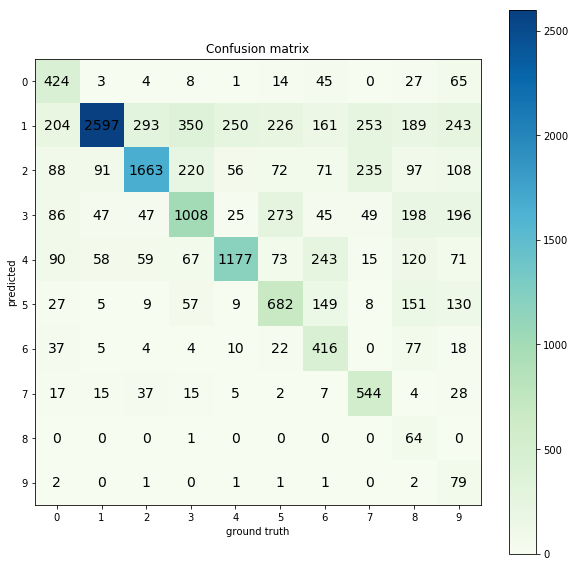

In [11]:
from sklearn import metrics
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    #confusion_matrix = np.zeros((10,10), np.int)
    
    # TODO: Implement filling the prediction matrix
    #return np.array([[40, 2, 3], [10, 50,0], [0, 2, 80]])
    return metrics.confusion_matrix(ground_truth, predictions).T

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

In [12]:
%matplotlib inline

data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,2))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        plt.show()
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    #raise Exception("Not implemented")
    #title = "Visualize: predicted_class is {predicted_class}, gt_class is {gt_class}"
    title = 'predicted: %s, actual: %s' % (predicted_class, gt_class)
    indices = val_indices[(groud_truth == gt_class) & (predictions == predicted_class)]
    
    visualize_images(indices, data, title, max_num=10)


visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

<Figure size 1000x200 with 0 Axes>

<Figure size 1000x200 with 0 Axes>

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [ ]:
# Experiment here!

In [13]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.5582


In [14]:
import math

batch_size = 64

layer1 = 100
layer2 = 100

learning_rate = 1e-3
reg_strength = 1e-4

epochs = 30

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

nn_model = nn.Sequential(
    Flattener(),
    
    nn.Linear(3*32*32, layer1),    
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(layer1),
    
    nn.Linear(layer1, layer2),    
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(layer2),
    
    nn.Linear(layer2, 10)
)


nn_model.type(torch.FloatTensor)

optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate, weight_decay=reg_strength)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.333, patience=3)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)


loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 30, scheduler)

Average loss: 1.324747, Train accuracy: 0.572945, Val accuracy: 0.701317
Average loss: 0.928750, Train accuracy: 0.708050, Val accuracy: 0.736946
Average loss: 0.752471, Train accuracy: 0.766543, Val accuracy: 0.786772
Average loss: 0.705842, Train accuracy: 0.781558, Val accuracy: 0.792096
Average loss: 0.626837, Train accuracy: 0.805174, Val accuracy: 0.815030
Average loss: 0.599587, Train accuracy: 0.814132, Val accuracy: 0.811276
Average loss: 0.554763, Train accuracy: 0.829659, Val accuracy: 0.826087
Average loss: 0.541286, Train accuracy: 0.832713, Val accuracy: 0.828135
Average loss: 0.517548, Train accuracy: 0.840733, Val accuracy: 0.831547
Average loss: 0.508581, Train accuracy: 0.842218, Val accuracy: 0.832503
Average loss: 0.498405, Train accuracy: 0.847319, Val accuracy: 0.835028
Average loss: 0.492711, Train accuracy: 0.847149, Val accuracy: 0.836530
Average loss: 0.489456, Train accuracy: 0.849845, Val accuracy: 0.836257
Average loss: 0.483939, Train accuracy: 0.850152, V

In [16]:
def loss_accuracy_plot(loss_history, train_history, val_history):
    plt.figure(figsize=(10, 7))
    plt.subplot(211)
    plt.title("Loss")
    plt.plot(loss_history)
    plt.subplot(212)
    plt.title("Train/validation accuracy")
    plt.plot(train_history, label="train")
    plt.plot(val_history, label="validation")
    plt.legend();

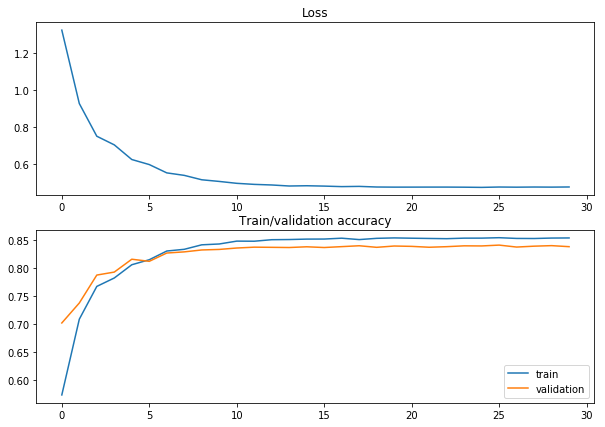

In [17]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [18]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8105


In [21]:
import math

batch_size = 64

layer1 = 100
layer2 = 100

learning_rate = 1e-3
reg_strength = 1e-4

epochs = 30

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

nn_model = nn.Sequential(
    Flattener(),
    
    nn.Linear(3*32*32, layer1),    
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(layer1),
    
    nn.Linear(layer1, layer2),    
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(layer2),
    
    nn.Linear(layer2, 10)
)


nn_model.type(torch.FloatTensor)

optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate, weight_decay=reg_strength)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.333, patience=3)
#scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, epochs)

Average loss: 1.329881, Train accuracy: 0.570880, Val accuracy: 0.685892
Average loss: 0.944466, Train accuracy: 0.703682, Val accuracy: 0.714217
Average loss: 0.830033, Train accuracy: 0.740487, Val accuracy: 0.766228
Average loss: 0.760975, Train accuracy: 0.761407, Val accuracy: 0.783359
Average loss: 0.712627, Train accuracy: 0.776917, Val accuracy: 0.794144
Average loss: 0.677265, Train accuracy: 0.789151, Val accuracy: 0.786636
Average loss: 0.653572, Train accuracy: 0.796011, Val accuracy: 0.806907
Average loss: 0.633480, Train accuracy: 0.803689, Val accuracy: 0.802539
Average loss: 0.626135, Train accuracy: 0.803826, Val accuracy: 0.807522
Average loss: 0.603066, Train accuracy: 0.812016, Val accuracy: 0.813392
Average loss: 0.597083, Train accuracy: 0.813040, Val accuracy: 0.804314
Average loss: 0.577582, Train accuracy: 0.817988, Val accuracy: 0.824244
Average loss: 0.575132, Train accuracy: 0.820001, Val accuracy: 0.813596
Average loss: 0.564351, Train accuracy: 0.822646, V

In [22]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.7898


In [23]:
import math

batch_size = 64

layer1 = 100
layer2 = 100

learning_rate = 1e-3
reg_strength = 1e-4

epochs = 30

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

nn_model = nn.Sequential(
    Flattener(),
    
    nn.Linear(3*32*32, layer1),    
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(layer1),
    
    nn.Linear(layer1, layer2),    
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(layer2),
    
    nn.Linear(layer2, 10)
)


nn_model.type(torch.FloatTensor)

optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate, weight_decay=reg_strength)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.333, patience=3)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2.5, gamma=0.5)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, epochs)

Average loss: 1.328445, Train accuracy: 0.567945, Val accuracy: 0.682343
Average loss: 0.932926, Train accuracy: 0.708784, Val accuracy: 0.752577
Average loss: 0.818037, Train accuracy: 0.743746, Val accuracy: 0.775442
Average loss: 0.754434, Train accuracy: 0.763983, Val accuracy: 0.778855
Average loss: 0.707101, Train accuracy: 0.778726, Val accuracy: 0.788956
Average loss: 0.674996, Train accuracy: 0.788127, Val accuracy: 0.786090
Average loss: 0.655204, Train accuracy: 0.794953, Val accuracy: 0.796874
Average loss: 0.630183, Train accuracy: 0.803740, Val accuracy: 0.808409
Average loss: 0.613772, Train accuracy: 0.807443, Val accuracy: 0.804450
Average loss: 0.603864, Train accuracy: 0.809781, Val accuracy: 0.816600
Average loss: 0.589817, Train accuracy: 0.814098, Val accuracy: 0.809638
Average loss: 0.583798, Train accuracy: 0.815889, Val accuracy: 0.799399
Average loss: 0.569220, Train accuracy: 0.820257, Val accuracy: 0.820490
Average loss: 0.570157, Train accuracy: 0.819302, V

In [24]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.7987


In [27]:
import math

batch_size = 64

layer1 = 100
layer2 = 100

learning_rate = 1e-3
reg_strength = 1e-4

epochs = 30

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

nn_model = nn.Sequential(
    Flattener(),
    
    nn.Linear(3*32*32, layer1),    
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(layer1),
    
    nn.Linear(100, 200),  # was added layer
    nn.BatchNorm1d(200), 
    nn.ReLU(inplace=True),
    
    nn.Linear(200, layer2),    
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(layer2),
    
    nn.Linear(layer2, 10)
)

nn_model.type(torch.FloatTensor)

optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate, weight_decay=reg_strength)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.333, patience=3)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, epochs)

Average loss: 1.334085, Train accuracy: 0.560984, Val accuracy: 0.702341
Average loss: 0.926822, Train accuracy: 0.707351, Val accuracy: 0.741315
Average loss: 0.805695, Train accuracy: 0.745640, Val accuracy: 0.772370
Average loss: 0.738411, Train accuracy: 0.766389, Val accuracy: 0.782336
Average loss: 0.681694, Train accuracy: 0.784288, Val accuracy: 0.793802
Average loss: 0.649069, Train accuracy: 0.794919, Val accuracy: 0.791618
Average loss: 0.621694, Train accuracy: 0.802751, Val accuracy: 0.797898
Average loss: 0.600829, Train accuracy: 0.811077, Val accuracy: 0.816327
Average loss: 0.578603, Train accuracy: 0.817271, Val accuracy: 0.812777
Average loss: 0.563662, Train accuracy: 0.821008, Val accuracy: 0.824108
Average loss: 0.547425, Train accuracy: 0.826281, Val accuracy: 0.805815
Average loss: 0.530530, Train accuracy: 0.832952, Val accuracy: 0.822947
Average loss: 0.523126, Train accuracy: 0.833618, Val accuracy: 0.815507
Average loss: 0.510858, Train accuracy: 0.837440, V

In [28]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.7961


In [ ]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 100  # have been increased the num_epochs
optimizer = optim.Adam(nn_model.parameters(), lr=1e-5, weight_decay=0) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, 70, scheduler)

Average loss: 2.130143, Train accuracy: 0.272037, Val accuracy: 0.443110
Average loss: 1.746936, Train accuracy: 0.503549, Val accuracy: 0.572384
Average loss: 1.499441, Train accuracy: 0.595809, Val accuracy: 0.637909
Average loss: 1.336147, Train accuracy: 0.644149, Val accuracy: 0.678111
Average loss: 1.219045, Train accuracy: 0.673481, Val accuracy: 0.694355
Average loss: 1.130136, Train accuracy: 0.694639, Val accuracy: 0.711078
Average loss: 1.057136, Train accuracy: 0.711275, Val accuracy: 0.728346
Average loss: 0.998472, Train accuracy: 0.721974, Val accuracy: 0.739745
Average loss: 0.947325, Train accuracy: 0.733730, Val accuracy: 0.751758
Average loss: 0.903649, Train accuracy: 0.742279, Val accuracy: 0.759607
Average loss: 0.865377, Train accuracy: 0.751425, Val accuracy: 0.767593
Average loss: 0.833287, Train accuracy: 0.758523, Val accuracy: 0.768070
Average loss: 0.805257, Train accuracy: 0.765928, Val accuracy: 0.777148
Average loss: 0.777307, Train accuracy: 0.773402, V

In [ ]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)